In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
import os
import sys
sys.path.append(os.path.abspath('abstract_flows'))
import arrow
import grid
import flows

In [2]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

# Para ecobici

In [3]:
estaciones_eco = np.load(dir + 'Adj_eco/matrices_estaciones/est_2019.npy')
#estaciones_eco = np.load('/Users/antoniomendez/Desktop/Tesis/Datos/Adj_eco/matrices_estaciones/est_2019.npy')

In [4]:
data_eco = pd.read_csv(dir + 'ecobici/ecobici_2019.csv')
data_eco.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,36,11444,67,2019-01-01,0:08:44,36,2019-01-01,0:14:03,5.316667
1,M,36,9196,55,2019-01-01,0:12:05,136,2019-01-01,0:42:11,30.100000
2,M,38,2612,29,2019-01-01,0:13:15,115,2019-01-01,0:37:47,24.533333
3,M,43,7463,29,2019-01-01,0:13:36,115,2019-01-01,0:38:04,24.466667
4,M,37,3987,136,2019-01-01,0:15:30,35,2019-01-01,0:22:47,7.283333


In [5]:
counter_eco = flows.count_trips_ecobici(data_eco, threshold=1, directed=True)
counter_eco.head()

,Est_A,Est_B,counts,prob
0,18,1,4443,0.000530
1,211,217,4056,0.000484
2,174,183,3986,0.000476
3,174,111,3896,0.000465
4,111,174,3602,0.000430


In [6]:
est_eco = np.concatenate((counter_eco['Est_A'].unique(), counter_eco['Est_B'].unique()))
est_eco = np.unique(est_eco)
est_eco = np.sort(est_eco)

In [7]:
len(est_eco)

480

In [8]:
recurrences_eco = []
for s in est_eco:
    current_data = counter_eco[(counter_eco['Est_A'] == s) | (counter_eco['Est_B'] == s)]
    recurrences_eco.append(np.sum(current_data['counts']))

In [9]:
recurrences_eco = np.array(recurrences_eco)

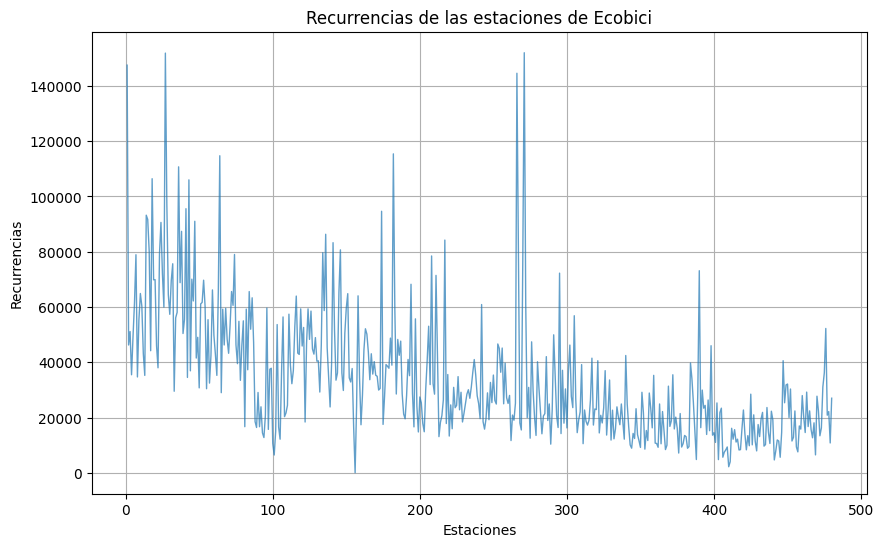

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(est_eco, recurrences_eco, linewidth=1, alpha=0.7)
plt.title('Recurrencias de las estaciones de Ecobici')
plt.xlabel('Estaciones')
plt.ylabel('Recurrencias')  
plt.grid()
plt.show()

In [11]:
est1_index = np.argmax(recurrences_eco)
est2_index = np.argsort(recurrences_eco)[-2]
est1_eco = est_eco[est1_index]
est2_eco = est_eco[est2_index]
print('Estación con más recurrencias:', est1_eco)
print('Segunda estación con más recurrencias:', est2_eco)

Estación con más recurrencias: 271
Segunda estación con más recurrencias: 27


In [12]:
dates = data_eco['Fecha_Retiro'].unique()
dates = np.sort(dates)
dates = dates[1:]
dates[:10]

array(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
       '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
       '2019-01-09', '2019-01-10'], dtype=object)

In [20]:
# tarda hasta 5 minutos
recurrences_est1_eco = []
recurrences_est2_eco = []
for date in dates:
    current_data = data_eco[data_eco['Fecha_Retiro'] == date]
    current_data1 = current_data[(current_data['Ciclo_Estacion_Retiro'] == est1_eco) | (current_data['Ciclo_Estacion_Arribo'] == est1_eco)]
    if current_data1.empty:
        recurrences_est1_eco.append(0)
    else:
        recurrences_est1_eco.append(np.sum(flows.count_trips_ecobici(current_data1, threshold=1, directed=True)['counts']))
    current_data2 = current_data[(current_data['Ciclo_Estacion_Retiro'] == est2_eco) | (current_data['Ciclo_Estacion_Arribo'] == est2_eco)]
    if current_data2.empty:
        recurrences_est2_eco.append(0)
    else:
        recurrences_est2_eco.append(np.sum(flows.count_trips_ecobici(current_data2, threshold=1, directed=True)['counts']))

In [25]:
recurrences_est1_eco = np.load('vector_files/recurrences_est1_eco.npy')
recurrences_est2_eco = np.load('vector_files/recurrences_est2_eco.npy')

In [53]:
grid_eco = grid.Grid(9,5,'ecobici')
map_eco = grid_eco.map_around()

for i in range(len(est_eco)):
    current_est = estaciones_eco[i, 0]
    current_index = np.where(est_eco == current_est)[0][0]
    current_recurrence = recurrences_eco[current_index]
    if estaciones_eco[i, 0] == est1_eco:
        folium.Marker([estaciones_eco[i, 1], estaciones_eco[i, 2]], popup=f'Estación {int(est1_eco)} - Recurrencia {current_recurrence}').add_to(map_eco)
    elif estaciones_eco[i, 0] == est2_eco:
        folium.Marker([estaciones_eco[i, 1], estaciones_eco[i, 2]], popup=f'Estación {int(est2_eco)} - Recurrencia {current_recurrence}').add_to(map_eco)
    else:
        folium.CircleMarker([estaciones_eco[i, 1], estaciones_eco[i, 2]], radius=0.5, popup=f'Estacion {int(estaciones_eco[i][0])} - Recurrencia {current_recurrence}').add_to(map_eco)
map_eco

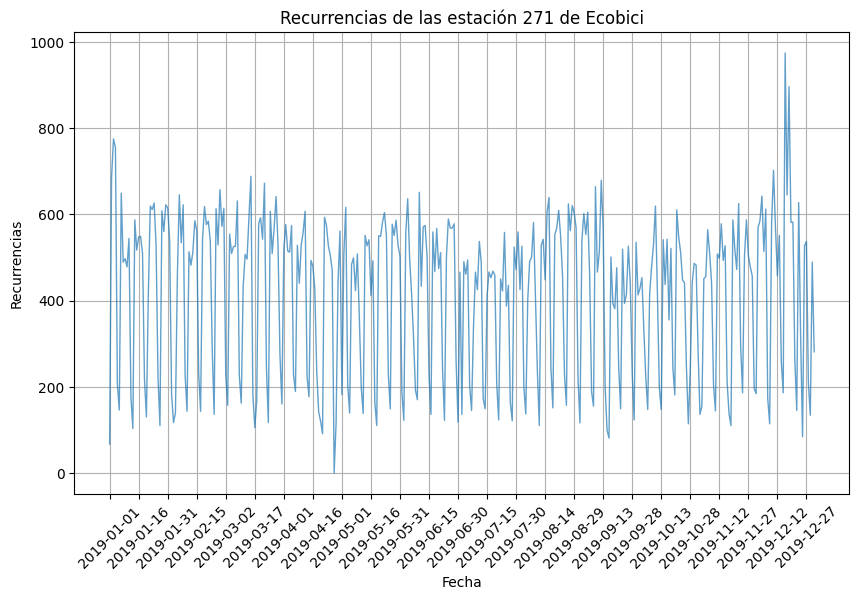

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(dates, recurrences_est1_eco, linewidth=1, alpha=0.7, label='Estación 1')
plt.title(f'Recurrencias de las estación {int(est1_eco)} de Ecobici')
plt.xlabel('Fecha')
plt.ylabel('Recurrencias')
plt.xticks(dates[::15], rotation=45)
plt.grid()
plt.show()

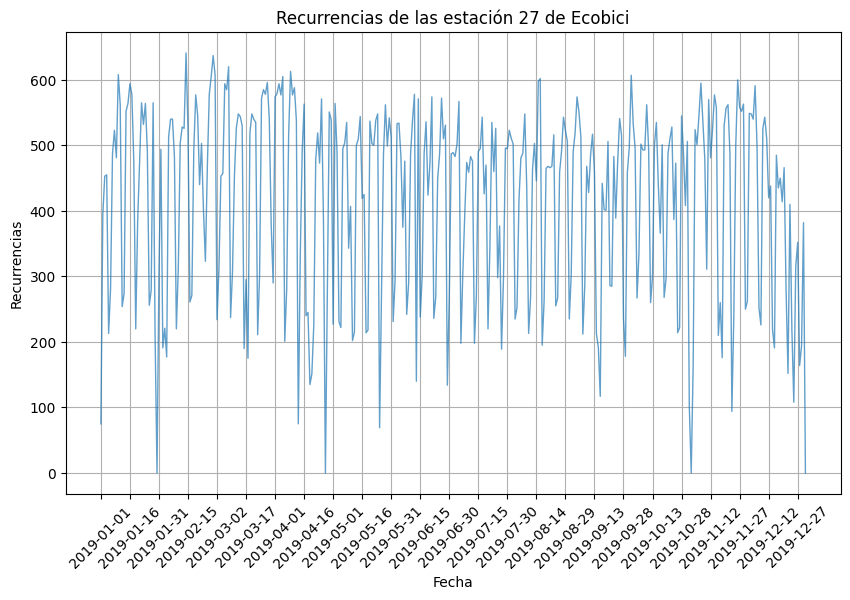

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(dates, recurrences_est2_eco, linewidth=1, alpha=0.7, label='Estación 2')
plt.title(f'Recurrencias de las estación {int(est2_eco)} de Ecobici')
plt.xlabel('Fecha')
plt.ylabel('Recurrencias')
plt.xticks(dates[::15], rotation=45)
plt.grid()
plt.show()

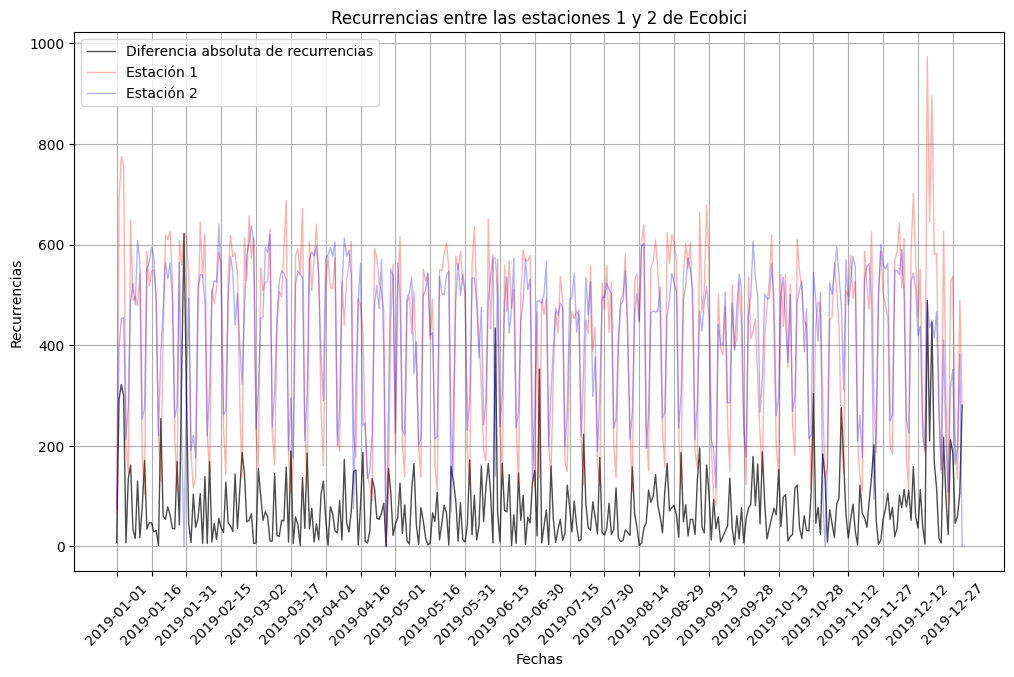

In [68]:
n = len(dates)
plt.figure(figsize=(12, 7))
plt.plot(dates[:n], np.abs(recurrences_est1_eco[:n] - recurrences_est2_eco[:n]), linewidth=1, alpha=0.7, c='black', label='Diferencia absoluta de recurrencias')
plt.plot(dates[:n], recurrences_est1_eco[:n], linewidth=1, alpha=0.3, c='red', label='Estación 1')
plt.plot(dates[:n], recurrences_est2_eco[:n], linewidth=1, alpha=0.3, c='blue', label='Estación 2')
plt.title('Recurrencias entre las estaciones 1 y 2 de Ecobici')
plt.xlabel('Fechas')
plt.ylabel('Recurrencias')
plt.xticks(dates[:n:15], rotation=45)
plt.legend()
plt.grid()
plt.show()

# Para Mibici

In [70]:
estaciones_mibici = np.load(dir + 'Adj_mibici/matrices_estaciones/est_2019.npy')
#estaciones_mibici = np.load('/Users/antoniomendez/Desktop/Tesis/Datos/Adj_mibici/matrices_estaciones/est_2019.npy')

In [71]:
data_mibici = pd.read_csv(dir + 'mibici/mibici_2019.csv')
data_mibici.head()

,Viaje_Id,Usuario_Id,Genero,Año_de_nacimiento,Inicio_del_viaje,Fin_del_viaje,Origen_Id,Destino_Id,Tiempo_viaje
0,8901295,341162,M,1992.0,2019-01-01 00:00:00,2019-01-01 00:16:09,50,54,16.150000
1,8901296,413443,M,1985.0,2019-01-01 06:01:05,2019-01-01 06:16:27,38,194,15.366667
2,8901297,444232,M,1995.0,2019-01-01 06:01:19,2019-01-01 06:09:55,86,18,8.600000
3,8901298,437533,M,1998.0,2019-01-01 06:01:25,2019-01-01 06:02:04,86,86,0.650000
4,8901299,430224,M,1992.0,2019-01-01 06:01:57,2019-01-01 06:05:01,27,52,3.066667


In [86]:
data_mibici = data_mibici[data_mibici['Origen_Id'] != 124]
data_mibici = data_mibici[data_mibici['Destino_Id'] != 124]

In [87]:
counter_mibici = flows.count_trips_mibici(data_mibici, threshold=1, directed=True)
counter_mibici.head()

,Est_A,Est_B,counts,prob
0,194,51,8682,0.001875
1,65,51,6719,0.001451
2,66,51,5197,0.001122
3,51,51,5139,0.001110
4,50,50,4963,0.001072


In [88]:
est_mibici = np.concatenate((counter_mibici['Est_A'].unique(), counter_mibici['Est_B'].unique()))
est_mibici = np.unique(est_mibici)
est_mibici = np.sort(est_mibici)

In [89]:
len(est_mibici)

274

In [90]:
recurrences_mibici = []
for s in est_mibici:
    current_data = counter_mibici[(counter_mibici['Est_A'] == s) | (counter_mibici['Est_B'] == s)]
    recurrences_mibici.append(np.sum(current_data['counts']))

recurrences_mibici = np.array(recurrences_mibici)

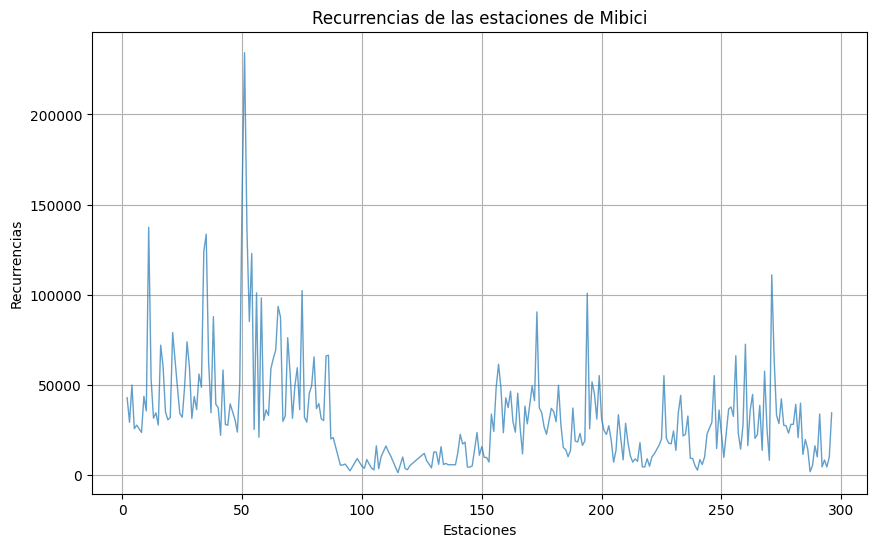

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(est_mibici, recurrences_mibici, linewidth=1, alpha=0.7)
plt.title('Recurrencias de las estaciones de Mibici')
plt.xlabel('Estaciones')
plt.ylabel('Recurrencias')
plt.grid()
plt.show()

In [92]:
est1_index_mibici = np.argmax(recurrences_mibici)
est2_index_mibici = np.argsort(recurrences_mibici)[-2]
est1_mibici = est_mibici[est1_index_mibici]
est2_mibici = est_mibici[est2_index_mibici]
print('Estación con más recurrencias:', est1_mibici)
print('Segunda estación con más recurrencias:', est2_mibici)

Estación con más recurrencias: 51
Segunda estación con más recurrencias: 50


In [93]:
dates = data_mibici['Inicio_del_viaje'].unique()
dates = [date[:10] for date in dates]
dates = np.unique(dates)
dates = np.sort(dates)
#dates = dates[1:]
dates[:10]

array(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
       '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
       '2019-01-09', '2019-01-10'], dtype='<U10')

In [ ]:
# puede tardar hasta 10 minutos idk
recurrences_est1_mibici = []
recurrences_est2_mibici = []

for date in dates:
    current_data = data_mibici[data_mibici['Inicio_del_viaje'].str.contains(date)]
    current_data1 = current_data[(current_data['Origen_Id'] == est1_mibici) | (current_data['Destino_Id'] == est1_mibici)]
    if current_data1.empty:
        recurrences_est1_mibici.append(0)
    else:
        recurrences_est1_mibici.append(np.sum(flows.count_trips_mibici(current_data1, threshold=1, directed=True)['counts']))
    current_data2 = current_data[(current_data['Origen_Id'] == est2_mibici) | (current_data['Destino_Id'] == est2_mibici)]
    if current_data2.empty:
        recurrences_est2_mibici.append(0)
    else:
        recurrences_est2_mibici.append(np.sum(flows.count_trips_mibici(current_data2, threshold=1, directed=True)['counts']))

In [97]:
recurrences_est1_mibici = np.load('vector_files/recurrences_est1_mibici.npy')
recurrences_est2_mibici = np.load('vector_files/recurrences_est2_mibici.npy')

In [94]:
grid_mibici = grid.Grid(5,5,'mibici')
map_mibici = grid_mibici.map_around()

for i in range(len(est_mibici)):
    current_est = estaciones_mibici[i, 0]
    current_index = np.where(est_mibici == current_est)[0][0]
    current_recurrence = recurrences_mibici[current_index]
    if estaciones_mibici[i, 0] == est1_mibici:
        folium.Marker([estaciones_mibici[i, 1], estaciones_mibici[i, 2]], popup=f'Estación {int(est1_mibici)} - Recurrencia {current_recurrence}').add_to(map_mibici)
    elif estaciones_mibici[i, 0] == est2_mibici:
        folium.Marker([estaciones_mibici[i, 1], estaciones_mibici[i, 2]], popup=f'Estación {int(est2_mibici)} - Recurrencia {current_recurrence}').add_to(map_mibici)
    else:
        folium.CircleMarker([estaciones_mibici[i, 1], estaciones_mibici[i, 2]], radius=0.5, popup=f'Estacion {int(estaciones_mibici[i][0])} - Recurrencia {current_recurrence}').add_to(map_mibici)
map_mibici

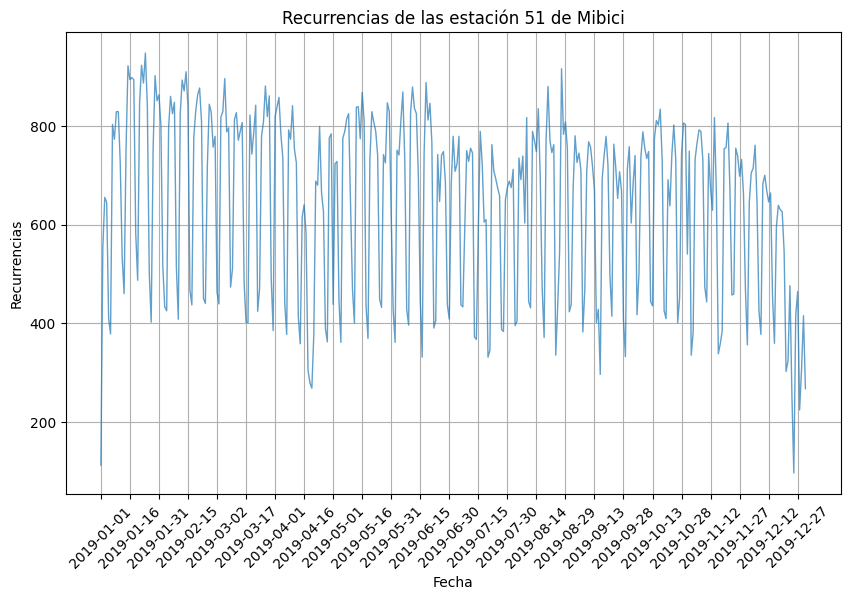

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(dates, recurrences_est1_mibici, linewidth=1, alpha=0.7, label='Estación 1')
plt.title(f'Recurrencias de las estación {int(est1_mibici)} de Mibici')
plt.xlabel('Fecha')
plt.ylabel('Recurrencias')
plt.xticks(dates[::15], rotation=45)
plt.grid()
plt.show()

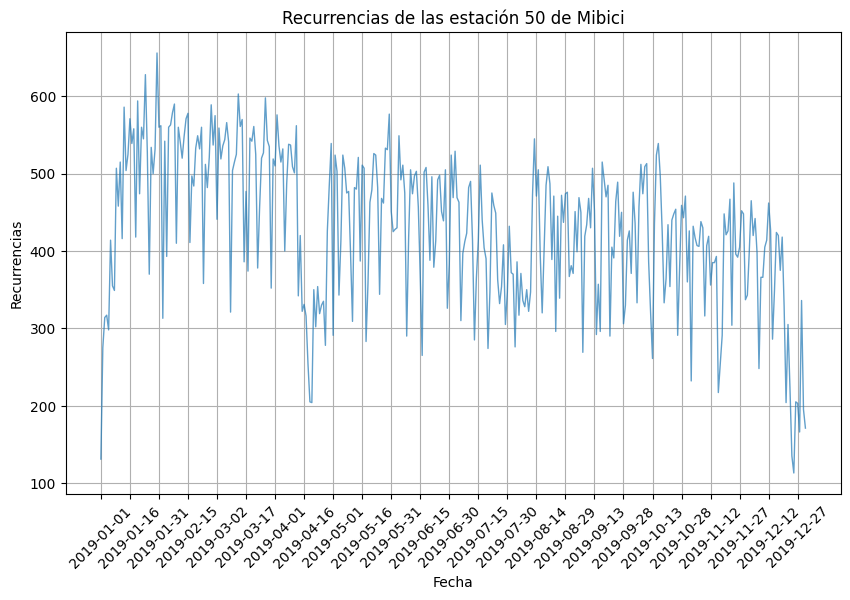

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(dates, recurrences_est2_mibici, linewidth=1, alpha=0.7, label='Estación 2')
plt.title(f'Recurrencias de las estación {int(est2_mibici)} de Mibici')
plt.xlabel('Fecha')
plt.ylabel('Recurrencias')
plt.xticks(dates[::15], rotation=45)
plt.grid()
plt.show()

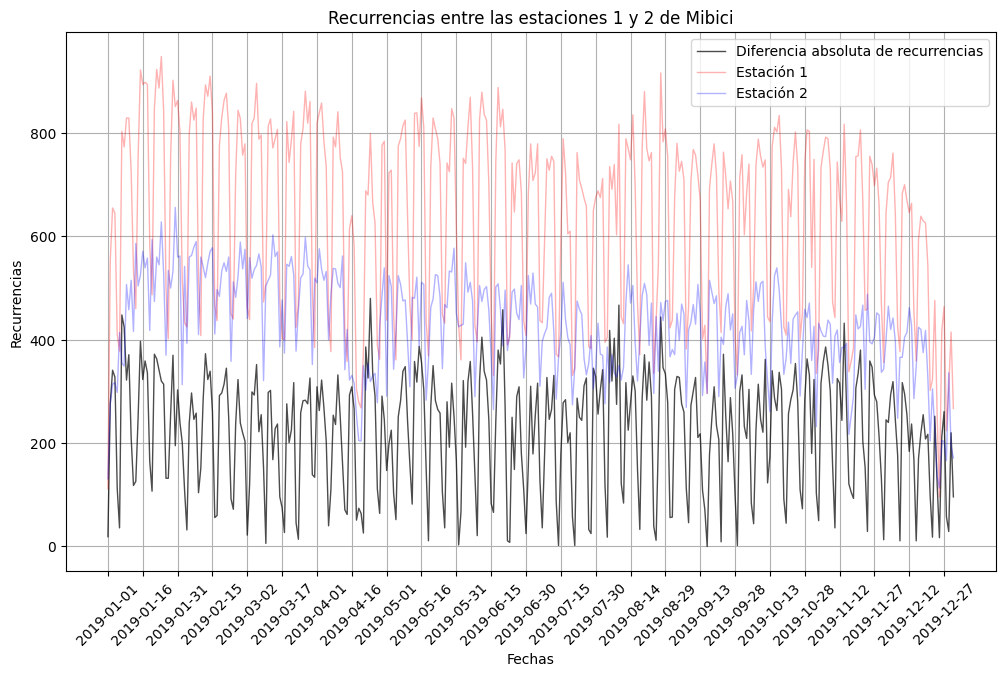

In [100]:
n = len(dates)
plt.figure(figsize=(12, 7))
plt.plot(dates[:n], np.abs(recurrences_est1_mibici[:n] - recurrences_est2_mibici[:n]), linewidth=1, alpha=0.7, c='black', label='Diferencia absoluta de recurrencias')
plt.plot(dates[:n], recurrences_est1_mibici[:n], linewidth=1, alpha=0.3, c='red', label='Estación 1')
plt.plot(dates[:n], recurrences_est2_mibici[:n], linewidth=1, alpha=0.3, c='blue', label='Estación 2')
plt.title('Recurrencias entre las estaciones 1 y 2 de Mibici')
plt.xlabel('Fechas')
plt.ylabel('Recurrencias')
plt.xticks(dates[:n:15], rotation=45)
plt.legend()
plt.grid()
plt.show()